In [1]:
import pandas as pd
import seaborn as sns

from netam import shmoof

In [2]:
full_shmoof_df = pd.read_csv("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", index_col=0).reset_index(drop=True)

train_df = full_shmoof_df.sample(frac=0.8)
val_df = full_shmoof_df.drop(train_df.index)

In [3]:
burrito = shmoof.SHMoofBurrito(train_df, val_df, max_length=500, kmer_length=5)
print("starting training...")
burrito.train(epochs=2)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/2]	 Loss: 0.02837904	 Val Loss: 0.02817232
Epoch [2/2]	 Loss: 0.02740253	 Val Loss: 0.02820703


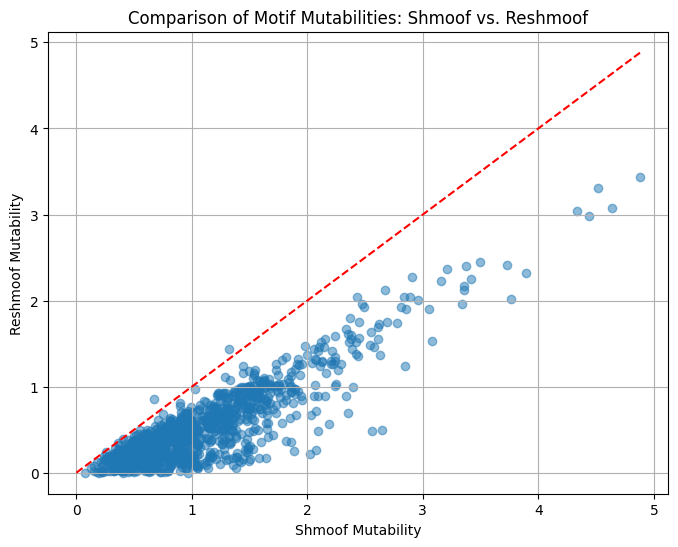

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

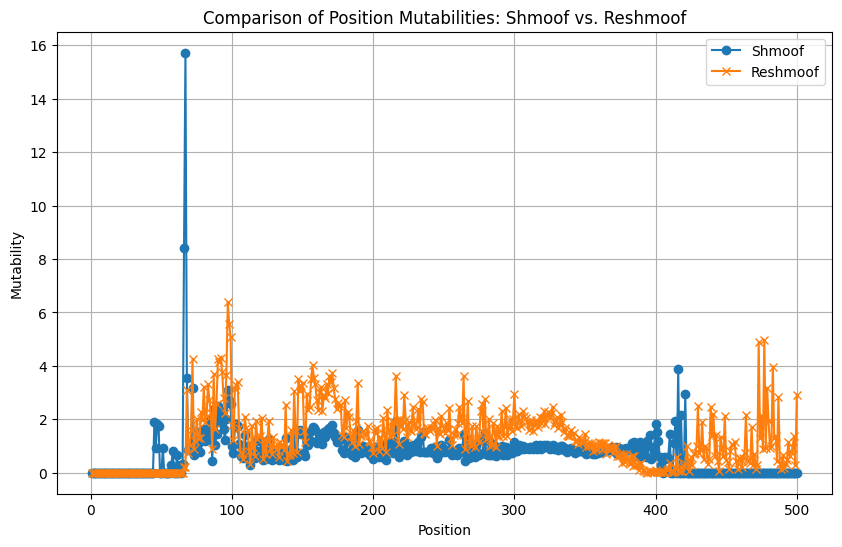

In [5]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof', marker='o')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof', marker='x')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()
